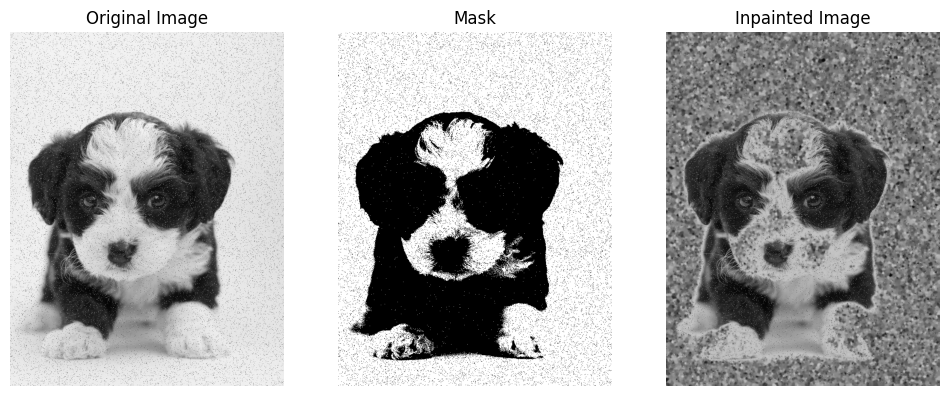

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('/content/maltese-puppy-with-noise.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.inRange(image, (200, 200, 200), (255, 255, 255))

inpainted_image = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Inpainted Image")
plt.imshow(inpainted_image)
plt.axis('off')

plt.show()

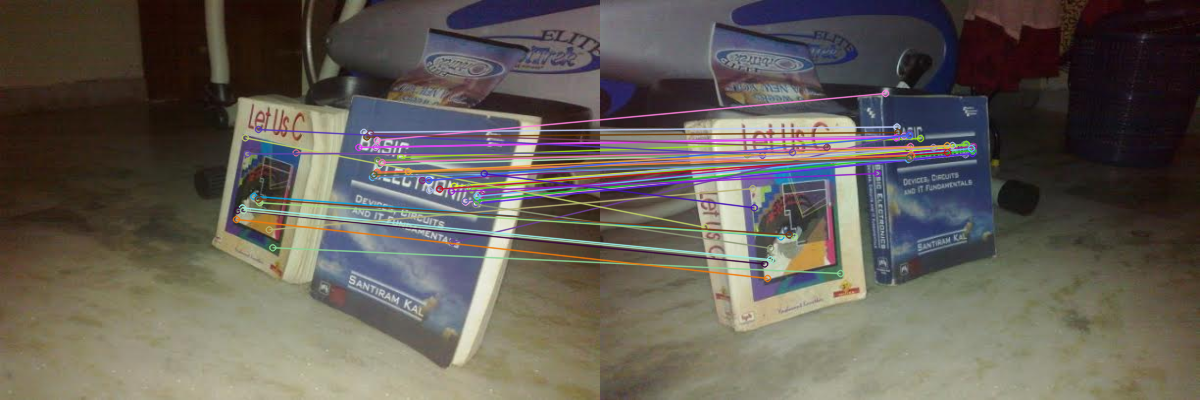

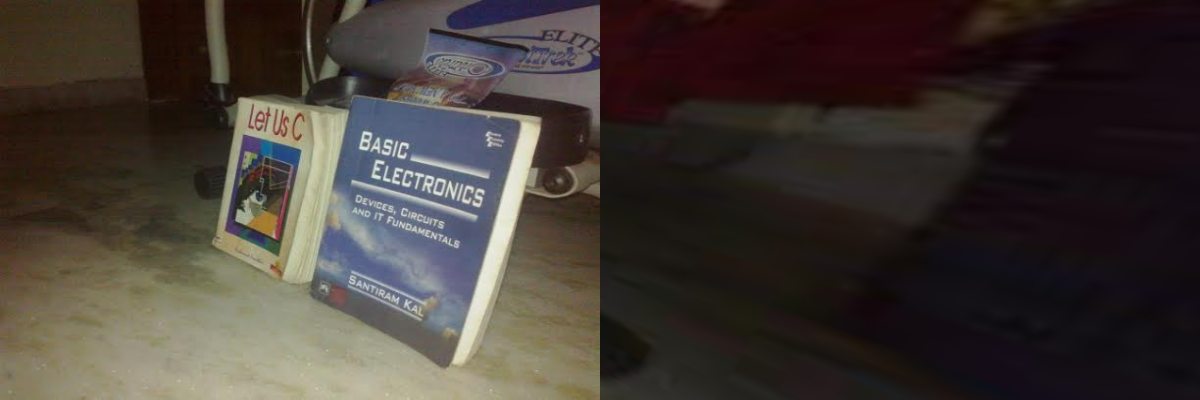

Fundamental Matrix:
 [[ 6.07029952e-06 -5.69775167e-06  7.70050928e-05]
 [ 1.70369453e-05  4.12198170e-06 -3.05784447e-03]
 [-4.39180904e-03 -2.36340315e-03  1.00000000e+00]]
Essential Matrix:
 [[ 0.03142714  0.58107937  0.11721684]
 [ 0.55988163 -0.03975429  0.41513349]
 [ 0.08717311 -0.39067767  0.00273231]]
Rotation:
 [[-0.34813574  0.2034262  -0.91510616]
 [-0.12511207  0.95735627  0.26041495]
 [ 0.92905784  0.20515058 -0.30783886]]
Translation:
 [[ 0.54335865]
 [-0.158848  ]
 [ 0.8243353 ]]


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from urllib.request import urlopen
import os

img_urls = [
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/right.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left.jpg"
]

os.makedirs("images", exist_ok=True)

for i, url in enumerate(img_urls):
    with open(f"images/img{i}.jpg", 'wb') as f:
        f.write(urlopen(url).read())

img1 = cv2.imread("images/img0.jpg")
img2 = cv2.imread("images/img1.jpg")

img1 = cv2.resize(img1, (600, 400))
img2 = cv2.resize(img2, (600, 400))

def stitch_images(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(descriptors1, descriptors2)

    matches = sorted(matches, key=lambda x: x.distance)

    match_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:50], None, flags=2)
    cv2_imshow(match_img)

    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    result = cv2.warpPerspective(img2, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
    result[0:img1.shape[0], 0:img1.shape[1]] = img1

    return result

stitched = stitch_images(img1, img2)
cv2_imshow(stitched)


def basic_sfm(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    pts1 = []
    pts2 = []

    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
            pts1.append(kp1[m.queryIdx].pt)
            pts2.append(kp2[m.trainIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)

    F, mask_f = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

    print("Fundamental Matrix:\n", F)

    h, w = gray1.shape
    f = 800
    K = np.array([[f, 0, w/2],
                  [0, f, h/2],
                  [0, 0, 1]])

    E, mask_e = cv2.findEssentialMat(pts1, pts2, K)
    print("Essential Matrix:\n", E)

    _, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)
    print("Rotation:\n", R)
    print("Translation:\n", t)

    return F, E, R, t

F, E, R, t = basic_sfm(img1, img2)

In [5]:
!apt-get install unrar -y

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar

!mkdir /content/UCF101
!unrar x UCF101.rar /content/UCF101/
import os

root_dir = '/content/UCF101/UCF-101'
if os.path.exists(root_dir):
    classes = os.listdir(root_dir)
    print(f"Total classes found: {len(classes)}")
    print("Sample classes:", classes[:10])
else:
    print("⚠️ Dataset not found. Check the extraction path.")

Streaming output truncated to the last 5000 lines.
Extracting  /content/UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c07.avi      62%  OK 
Extracting  /content/UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c01.avi      62%  OK 
Extracting  /content/UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c02.avi      62%  OK 
Extracting  /content/UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c03.avi      62%  OK 
Extracting  /content/UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c04.avi      62%  OK 
Extracting  /content/UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c05.avi      62%  OK 
Extracting  /content/UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c06.avi      62%  OK 
Extracting  /content/UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi      62%  OK 
Extracting  /content/UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c01.avi      62%  OK 
Extracting  /content/UCF101/UCF-101/Play

In [3]:
import os
import shutil
import random

SOURCE_DIR = '/content/UCF101/UCF-101'
DEST_DIR = '/content/UCF101_subset'
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

os.makedirs(DEST_DIR, exist_ok=True)

for cls in SELECTED_CLASSES:
    class_path = os.path.join(SOURCE_DIR, cls)
    dest_class_path = os.path.join(DEST_DIR, cls)
    os.makedirs(dest_class_path, exist_ok=True)

    video_files = [f for f in os.listdir(class_path) if f.endswith('.avi')]
    selected = random.sample(video_files, VIDEOS_PER_CLASS)

    for video in selected:
        shutil.copy(os.path.join(class_path, video), dest_class_path)

print("✅ Subset created with 5 classes at:", DEST_DIR)


✅ Subset created with 5 classes at: /content/UCF101_subset


In [4]:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

FRAME_SIZE = (112, 112)
FRAMES_PER_VIDEO = 16
FRAME_STEP = 5

X = []
y = []

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if count % FRAME_STEP == 0:
            frame = cv2.resize(frame, FRAME_SIZE)
            frames.append(frame)
        count += 1
    cap.release()
    return frames

for class_name in SELECTED_CLASSES:
    folder = os.path.join(DEST_DIR, class_name)
    for file in os.listdir(folder):
        video_path = os.path.join(folder, file)
        frames = extract_frames(video_path)
        if len(frames) >= FRAMES_PER_VIDEO:
            frames = frames[:FRAMES_PER_VIDEO]
            X.append(frames)
            y.append(class_name)

X = np.array(X) / 255.0
y_encoded = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("✅ Data ready. Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


✅ Data ready. Shapes:
X_train: (78, 16, 112, 112, 3) y_train: (78,)
X_test: (20, 16, 112, 112, 3) y_test: (20,)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

model = Sequential([
    Conv3D(32, (3,3,3), activation='relu', input_shape=(FRAMES_PER_VIDEO, *FRAME_SIZE, 3)),
    MaxPooling3D((2,2,2)),
    Conv3D(64, (3,3,3), activation='relu'),
    MaxPooling3D((2,2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(SELECTED_CLASSES), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 110, 110, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 55, 55, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 53, 53, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 26, 26, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 86528)             0         
                                                                 
 dense (Dense)               (None, 128)               1

1/1 [==============================] - 4s 4s/step

Classification Report:

               precision    recall  f1-score   support

   Basketball       1.00      0.25      0.40         4
       Biking       1.00      0.75      0.86         4
PlayingGuitar       0.67      0.50      0.57         4
       Typing       0.67      1.00      0.80         4
     JumpRope       0.57      1.00      0.73         4

     accuracy                           0.70        20
    macro avg       0.78      0.70      0.67        20
 weighted avg       0.78      0.70      0.67        20



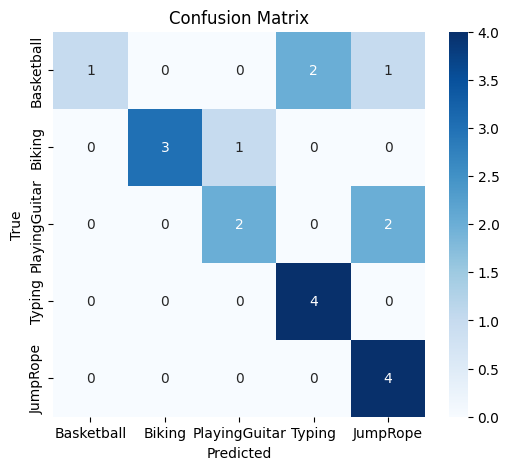

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_labels, target_names=SELECTED_CLASSES))

cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=SELECTED_CLASSES, yticklabels=SELECTED_CLASSES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
